In [ ]:
import tensorflow as tf
import numpy as np
import cmsisdsp as dsp
import random

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D

import sys
sys.path.append('/home/mat/dev/cached_dilated_causal_convolutions/') #cmsisdsp_py_version/')

from cmsisdsp_py_version.block import Block
from cmsisdsp_py_version.rolling_cache import RollingCache
from cmsisdsp_py_version.keras_model import create_dilated_model

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

records_long = []
records_wide = []
n = 0
for line in open('../serial_dump_from_daisy.txt', 'r'):
    try:
        if line.startswith('b'): 
            cv = float(line.split(" ")[2])
        else:
            in_v, out_v = map(float, line.split(" "))
            records_long.append((n, 'cv', cv))
            records_long.append((n, 'in_v', in_v))
            records_long.append((n, 'out_v', out_v))
            records_wide.append((n, cv, in_v, out_v))
            n += 1
    except Exception as e:
        print(f"? [{line.strip()}] ({str(e)})")
df_long = pd.DataFrame(records_long, columns=['n', 'name', 'val'])
df_wide = pd.DataFrame(records_wide, columns=['n', 'cv', 'in_v', 'out_v'])

<Axes: xlabel='n', ylabel='cv'>

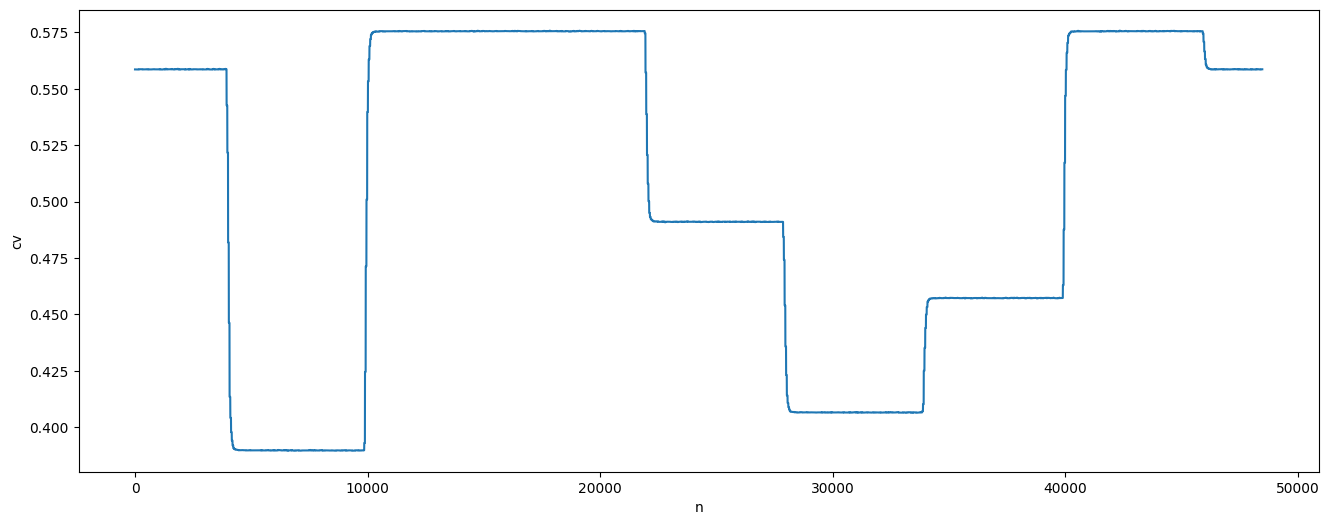

In [3]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_wide, x='n', y='cv')

<Axes: xlabel='n', ylabel='val'>

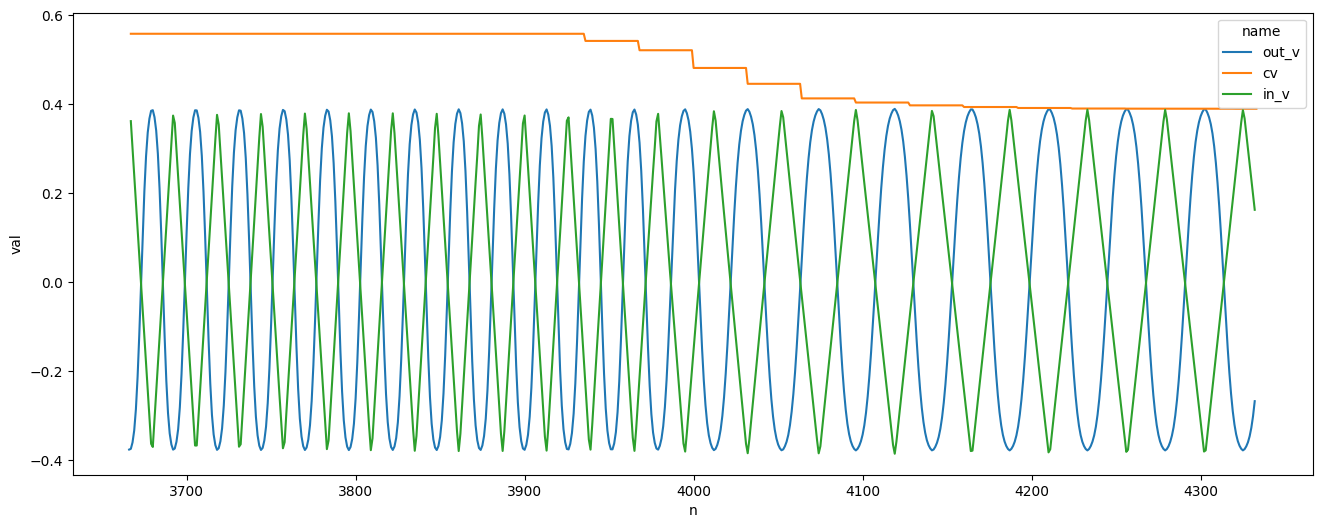

In [4]:
plt.figure(figsize=(16, 6))
sns.lineplot(df_long[11000:13000], x='n', y='val', hue='name')

In [5]:
cvs = np.array(df_wide['cv'])
in_vs = np.array(df_wide['in_v'])
x = np.stack([cvs, in_vs]).transpose()

y_true = np.expand_dims(np.array(df_wide['out_v']), -1)

split = int(len(x) * 0.8)

print(split, cvs.shape, in_vs.shape, x.shape)

38787 (48484,) (48484,) (48484, 2)


In [6]:
train_x, train_y = x[:split], y_true[:split]
test_x, test_y = x[split:], y_true[split:]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(38787, 2) (38787, 1) (9697, 2) (9697, 1)


In [7]:
IN_D = 2             # input depth
K = 4                # kernel size and implied dilation rate
FILTER_SIZES = [4, 8, 8]  # filters for Nth layer Kx1 and 1x1 convs
OUT_D = 1

TEST_SEQ_LEN = K**len(FILTER_SIZES)   # a**b for kernel size a, and b stacked layers
TRAIN_SEQ_LEN = int(TEST_SEQ_LEN * 1.5)

print("TRAIN_SEQ_LEN", TRAIN_SEQ_LEN)
print("TEST_SEQ_LEN", TEST_SEQ_LEN)

TRAIN_SEQ_LEN 96
TEST_SEQ_LEN 64


In [21]:
def create_configured_keras_model(seq_len, all_outputs):
    return create_dilated_model(
        seq_len, in_d=IN_D, filter_sizes=FILTER_SIZES,
        kernel_size=K, out_d=OUT_D,
        all_outputs=all_outputs)

In [22]:
train_model = create_configured_keras_model(TRAIN_SEQ_LEN, all_outputs=False)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 2)]           0         
                                                                 
 c0a (Conv1D)                (None, 96, 4)             36        
                                                                 
 c0b (Conv1D)                (None, 96, 4)             20        
                                                                 
 c1a (Conv1D)                (None, 96, 8)             136       
                                                                 
 c1b (Conv1D)                (None, 96, 8)             72        
                                                                 
 c2a (Conv1D)                (None, 96, 8)             264       
                                                                 
 c2b (Conv1D)                (None, 96, 8)             72  

In [23]:
from tensorflow.keras.optimizers import Adam

assert len(train_x) > TRAIN_SEQ_LEN

def gen():    
    for i in range(len(train_x)-TRAIN_SEQ_LEN-1):
        x = train_x[i:i+TRAIN_SEQ_LEN]
        y = train_y[i+1:i+1+TRAIN_SEQ_LEN]
        yield x, y
                 
ds = tf.data.Dataset.from_generator(gen, 
    output_signature=(tf.TensorSpec(shape=(TRAIN_SEQ_LEN, IN_D), dtype=tf.float32),
                      tf.TensorSpec(shape=(TRAIN_SEQ_LEN, OUT_D), dtype=tf.float32)))
ds = ds.cache().shuffle(1000).batch(32)
train_model.compile(Adam(1e-4), loss='mse')
train_model.fit(ds, epochs=5)


Epoch 1/5


2023-09-04 20:52:56.405649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-04 20:52:56.405799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1210/1210 [==============================] - 4s 3ms/step - loss: 0.0327
Epoch 2/5
1210/1210 [==============================] - 3s 3ms/step - loss: 0.0055
Epoch 3/5
1210/1210 [==============================] - 3s 3ms/step - loss: 0.0019
Epoch 4/5
1210/1210 [==============================] - 3s 3ms/step - loss: 9.0123e-04
Epoch 5/5
1210/1210 [==============================] - 3s 3ms/step - loss: 5.5641e-04


In [25]:
test_model = create_configured_keras_model(TEST_SEQ_LEN, all_outputs=True)
test_model.set_weights(train_model.get_weights())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 2)]           0         
                                                                 
 c0a (Conv1D)                (None, 64, 4)             36        
                                                                 
 c0b (Conv1D)                (None, 64, 4)             20        
                                                                 
 c1a (Conv1D)                (None, 64, 8)             136       
                                                                 
 c1b (Conv1D)                (None, 64, 8)             72        
                                                                 
 c2a (Conv1D)                (None, 64, 8)             264       
                                                                 
 c2b (Conv1D)                (None, 64, 8)             72  

In [26]:
test_seq = np.expand_dims(test_x[10:10+TEST_SEQ_LEN], 0)

assert test_seq.shape == (1, TEST_SEQ_LEN, IN_D)

test_seq[0,-10:]

array([[ 0.4572155,  0.1905427],
       [ 0.4572155,  0.1474881],
       [ 0.4572155,  0.1053178],
       [ 0.4572155,  0.0623879],
       [ 0.4572155,  0.0200417],
       [ 0.4572155, -0.0227661],
       [ 0.4572155, -0.0649512],
       [ 0.4572155, -0.108469 ],
       [ 0.4572155, -0.1513321],
       [ 0.4572155, -0.1944811]])

In [27]:
model_out = test_model(test_seq)
model_out = [v.numpy() for v in model_out]
model_out = [v[0] for v in model_out]            # drop batch, which is always 1
all_steps_y_pred = model_out[-1]
all_steps_y_pred[-10:]

array([[-0.26147044],
       [-0.19488832],
       [-0.12194962],
       [-0.05664267],
       [ 0.0261187 ],
       [ 0.10746549],
       [ 0.18620631],
       [ 0.24564731],
       [ 0.2984326 ],
       [ 0.33235878]], dtype=float32)

In [28]:
#c1a_out, c1b_out, c2a_out, c2b_out, c3a_out, c3b_out, 
y_pred_out = model_out[-1]
y_pred_out.shape

(64, 1)

In [29]:
final_step_y_pred = all_steps_y_pred[-1,0]
final_step_y_pred

0.33235878

In [30]:
y_true = test_y[10+TEST_SEQ_LEN][0]
y_true

0.3337486

# caching

introduce a rolling cache so layer 0 and 1 need only be called once per `apply`

In [31]:
class CachedBlockModel(object):
    def __init__(self, 
                 block0, block1, block2,
                 classifier_kernel, classifier_bias):        
        
        self.block0 = block0
        self.block1 = block1
        self.block2 = block2
        
        self.classifier_kernel = classifier_kernel
        self.classifier_bias = classifier_bias  
        
        self.kernel_size = block0.kernel_size
        
        # buffer for layer0 input
        self.input = np.zeros((self.kernel_size, IN_D), dtype=np.float32)     
        
        # rolling window cache of layer0 output
        # n-1th entry in output lags nth entry by 3
        self.layer0_cache = RollingCache(            
            depth=self.block0.c2_out_d,
            dilation=self.kernel_size, kernel_size=self.kernel_size)
        
        # rolling window cache of layer1 output
        # n-1th entry in output lags nth entry by 9
        self.layer1_cache = RollingCache(            
            depth=self.block1.c2_out_d,
            dilation=self.kernel_size**2, kernel_size=self.kernel_size)
        
    def apply(self, x):
        assert x.shape == (2,), x.shape        
        # clumsy shift input, will do something better in firmware
        for i in range(self.kernel_size-1):
            self.input[i] = self.input[i+1]
        self.input[self.kernel_size-1] = x
        
        # run the layer 0 block ONCE 
        # add to cache then lookup output of the window
        block0_out = self.block0.apply(self.input)
        self.layer0_cache.add(block0_out)
        cached_layer0_outputs = self.layer0_cache.cached_dilated_values()
        
        # feed dildated cached values to layer 1
        # again with cached lagged values
        block1_out = self.block1.apply(cached_layer0_outputs)
        self.layer1_cache.add(block1_out)
        cached_layer1_outputs = self.layer1_cache.cached_dilated_values()
        
        # only ever need to run final dilation layer once
        block2_out = self.block2.apply(cached_layer1_outputs)
        
        # run y_pred
        # TODO: port to arm math too
        y_pred = np.dot(block2_out, self.classifier_kernel.squeeze()) + self.classifier_bias
        return y_pred
                
        
block0 = Block(
    c1_kernel = test_model.layers[1].weights[0].numpy(),
    c1_bias = test_model.layers[1].weights[1].numpy(),
    c2_kernel = test_model.layers[2].weights[0].numpy(),
    c2_bias = test_model.layers[2].weights[1].numpy(),
)

block1 = Block(
    c1_kernel = test_model.layers[3].weights[0].numpy(),
    c1_bias = test_model.layers[3].weights[1].numpy(),
    c2_kernel = test_model.layers[4].weights[0].numpy(),
    c2_bias = test_model.layers[4].weights[1].numpy(),
)

block2 = Block(
    c1_kernel = test_model.layers[5].weights[0].numpy(),
    c1_bias = test_model.layers[5].weights[1].numpy(),
    c2_kernel = test_model.layers[6].weights[0].numpy(),
    c2_bias = test_model.layers[6].weights[1].numpy(),
)

model = CachedBlockModel(
    block0, block1, block2,
    classifier_kernel = test_model.layers[7].weights[0].numpy(),
    classifier_bias = test_model.layers[7].weights[1].numpy()    
)        

In [32]:
# create a test model with a sequence > receptive field of the model

LONGER_TEST_SEQ_LEN = int(TEST_SEQ_LEN * 1.5)
assert LONGER_TEST_SEQ_LEN > TEST_SEQ_LEN

longer_test_model = create_configured_keras_model(LONGER_TEST_SEQ_LEN, all_outputs=True)
longer_test_model.set_weights(test_model.get_weights())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 2)]           0         
                                                                 
 c0a (Conv1D)                (None, 96, 4)             36        
                                                                 
 c0b (Conv1D)                (None, 96, 4)             20        
                                                                 
 c1a (Conv1D)                (None, 96, 8)             136       
                                                                 
 c1b (Conv1D)                (None, 96, 8)             72        
                                                                 
 c2a (Conv1D)                (None, 96, 8)             264       
                                                                 
 c2b (Conv1D)                (None, 96, 8)             72  

In [33]:
# run a longer test sequence through the keras model
# note: we expect a warmup of 3**3=27 steps for this 3 layer
# network as it processed the left padded zeros

longer_test_seq = np.expand_dims(test_x[:LONGER_TEST_SEQ_LEN], 0)
assert longer_test_seq.shape == (1, LONGER_TEST_SEQ_LEN, 2)

model_out = longer_test_model(longer_test_seq)
model_out = [v.numpy() for v in model_out]
model_out = [v[0] for v in model_out]            # drop batch, which is always 1
#c1a_output, c1b_output, c2a_output, c2b_output, c3a_output, c3b_output, 
y_pred_keras = model_out[-1]
y_pred_keras.flatten()

array([ 0.2625567 ,  0.3340948 ,  0.35609215,  0.3596006 ,  0.36775148,
        0.37749138,  0.35954237,  0.34807643,  0.26094362,  0.21474573,
        0.12216827,  0.07828354,  0.0117114 , -0.05398922, -0.15713942,
       -0.2244843 , -0.28362063, -0.30717117, -0.33892038, -0.3545875 ,
       -0.36624452, -0.36350545, -0.36673716, -0.36370263, -0.3610241 ,
       -0.35488057, -0.33432433, -0.29795554, -0.23584288, -0.14466387,
       -0.07911534, -0.00088089,  0.07217132,  0.14714122,  0.21384251,
        0.2710547 ,  0.31815875,  0.33598104,  0.35477597,  0.37509426,
        0.39469162,  0.39184487,  0.38133377,  0.3735502 ,  0.33761147,
        0.2856102 ,  0.23013937,  0.1617798 ,  0.09394321,  0.03317349,
       -0.04833642, -0.14246315, -0.2256282 , -0.28143972, -0.316353  ,
       -0.34550604, -0.36413357, -0.36526045, -0.3763437 , -0.37600252,
       -0.37378842, -0.3582913 , -0.3314863 , -0.29994583, -0.25335994,
       -0.18724391, -0.1225046 , -0.04883189,  0.03072666,  0.11

In [34]:
print(longer_test_seq.shape)

y_preds = []
for i in range(LONGER_TEST_SEQ_LEN):    
    next_step_y_pred = model.apply(longer_test_seq[0, i])
    y_preds.append(next_step_y_pred)

y_preds = np.stack(y_preds).flatten()
y_preds

(1, 96, 2)


array([ 0.26255664,  0.33409476,  0.35609215,  0.35960057,  0.36775148,
        0.3774914 ,  0.35954237,  0.34807643,  0.2609436 ,  0.21474573,
        0.12216827,  0.07828355,  0.01171139, -0.05398924, -0.15713954,
       -0.22448426, -0.28362063, -0.30717108, -0.33892038, -0.35458758,
       -0.36624444, -0.36350545, -0.3667371 , -0.36370265, -0.36102408,
       -0.3548805 , -0.33432427, -0.29795554, -0.235843  , -0.14466402,
       -0.07911541, -0.00088111,  0.07217141,  0.14714108,  0.21384242,
        0.27105474,  0.31815872,  0.33598095,  0.35477602,  0.37509423,
        0.39469162,  0.3918449 ,  0.38133377,  0.3735502 ,  0.33761147,
        0.28561017,  0.23013934,  0.16177973,  0.09394321,  0.03317345,
       -0.04833644, -0.14246318, -0.22562823, -0.28143975, -0.31635296,
       -0.34550595, -0.36413363, -0.36526036, -0.37634382, -0.37600255,
       -0.37378833, -0.3582912 , -0.33148628, -0.29994586, -0.25336003,
       -0.18724403, -0.12250447, -0.04883186,  0.03072647,  0.11

In [35]:
y_pred_keras.flatten()

array([ 0.2625567 ,  0.3340948 ,  0.35609215,  0.3596006 ,  0.36775148,
        0.37749138,  0.35954237,  0.34807643,  0.26094362,  0.21474573,
        0.12216827,  0.07828354,  0.0117114 , -0.05398922, -0.15713942,
       -0.2244843 , -0.28362063, -0.30717117, -0.33892038, -0.3545875 ,
       -0.36624452, -0.36350545, -0.36673716, -0.36370263, -0.3610241 ,
       -0.35488057, -0.33432433, -0.29795554, -0.23584288, -0.14466387,
       -0.07911534, -0.00088089,  0.07217132,  0.14714122,  0.21384251,
        0.2710547 ,  0.31815875,  0.33598104,  0.35477597,  0.37509426,
        0.39469162,  0.39184487,  0.38133377,  0.3735502 ,  0.33761147,
        0.2856102 ,  0.23013937,  0.1617798 ,  0.09394321,  0.03317349,
       -0.04833642, -0.14246315, -0.2256282 , -0.28143972, -0.316353  ,
       -0.34550604, -0.36413357, -0.36526045, -0.3763437 , -0.37600252,
       -0.37378842, -0.3582913 , -0.3314863 , -0.29994583, -0.25335994,
       -0.18724391, -0.1225046 , -0.04883189,  0.03072666,  0.11

In [36]:
np.all(np.isclose(y_preds[27:], y_pred_keras.flatten()[27:], atol=1e-5))

True